
Добавление периодического шума:


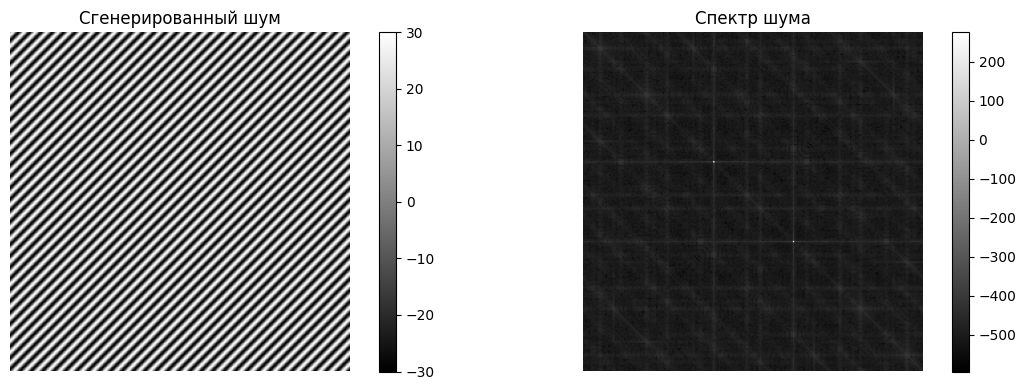


Применение Фурье-фильтра:


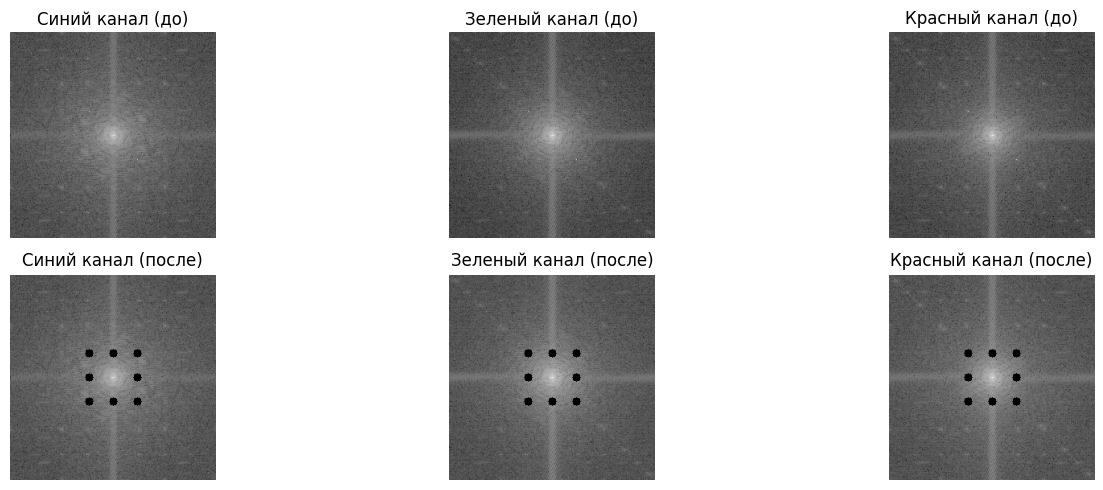

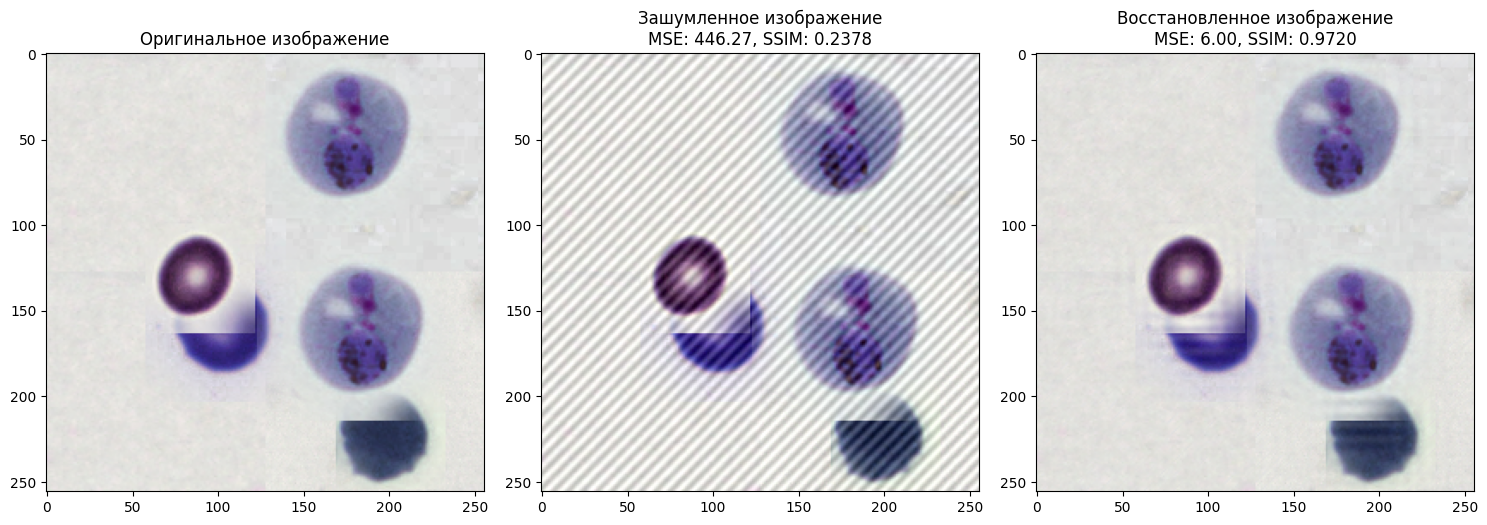

In [22]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity

def load_patches_from_folder(folder_path):
    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):
    selected_patches = random.choices(background_patches, k=num_patches)
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:
                patch = selected_patches.pop()
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))
                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except ValueError as e:
                    print(f"Ошибка при размещении патча: {e}")
                    continue
            else:
                break
    return background

def overlay_cells_on_background(background, cell_patches, num_cells=5):
    output = background.copy()
    for _ in range(num_cells):
        cell = random.choice(cell_patches)
        cell = cv2.resize(cell, (cell.shape[1] // 2, cell.shape[0] // 2))

        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])

        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        cv2.circle(mask, (cell.shape[1] // 2, cell.shape[0] // 2), radius, (255, 255, 255), -1)
        mask = cv2.GaussianBlur(mask, (51, 51), 0)
        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )
    return output

def add_periodic_noise_fourier(image, freq=30, amplitude=30):
    noisy_image = np.zeros_like(image, dtype=np.float32)
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    noise = amplitude * np.sin(2 * np.pi * freq * xx / image.shape[1] +
                          2 * np.pi * freq * yy / image.shape[0])

    # визуализация шума и его спектра
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(noise, cmap='gray')
    plt.title('Сгенерированный шум')
    plt.colorbar()
    plt.axis('off')

    fft_noise = np.fft.fft2(noise)
    fft_shift = np.fft.fftshift(fft_noise)
    magnitude_spectrum = 20 * np.log(np.abs(fft_shift))

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Спектр шума')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    for c in range(image.shape[2]):
        noisy_image[:, :, c] = image[:, :, c] + noise

    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def remove_noise_fourier(noisy_image, freq=30, threshold=20):
    restored_image = np.zeros_like(noisy_image, dtype=np.float32)

    # визуализация Фурье-спектра до и после фильтрации
    plt.figure(figsize=(15, 5))

    for c, color in enumerate(['Синий', 'Зеленый', 'Красный']):
        channel = noisy_image[:, :, c]

        # спектр до
        dft = np.fft.fft2(channel)
        dft_shift = np.fft.fftshift(dft)
        magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

        plt.subplot(2, 3, c+1)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title(f'{color} канал (до)')
        plt.axis('off')

        # маска фильтра
        rows, cols = channel.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols), np.uint8)
        radius = 5
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                cv2.circle(mask, (ccol + i*freq, crow + j*freq), radius, 0, -1)
                cv2.circle(mask, (ccol - i*freq, crow - j*freq), radius, 0, -1)

        fshift = dft_shift * mask

        # спектр после
        plt.subplot(2, 3, c+4)
        plt.imshow(20 * np.log(np.abs(fshift) + 1), cmap='gray')
        plt.title(f'{color} канал (после)')
        plt.axis('off')

        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        restored_image[:, :, c] = np.abs(img_back)

    plt.tight_layout()
    plt.show()

    return np.clip(restored_image, 0, 255).astype(np.uint8)

def calculate_metrics(original, processed):
    mse = mean_squared_error(original, processed)
    ssim = structural_similarity(original, processed, multichannel=True, channel_axis=2)
    return mse, ssim

patches_folder = '/content/patches'
background_folder = os.path.join(patches_folder, 'background')
cells_folder = os.path.join(patches_folder, 'cells')

background_patches = load_patches_from_folder(background_folder)
cell_patches = load_patches_from_folder(cells_folder)
background = generate_background_from_patches(background_patches)
image_with_cells = overlay_cells_on_background(background, cell_patches)

print("\nДобавление периодического шума:")
noisy_image = add_periodic_noise_fourier(image_with_cells, freq=30, amplitude=30)

print("\nПрименение Фурье-фильтра:")
restored_image = remove_noise_fourier(noisy_image, freq=30)

mse_noise, ssim_noise = calculate_metrics(image_with_cells, noisy_image)
mse_restored, ssim_restored = calculate_metrics(image_with_cells, restored_image)

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(image_with_cells, cv2.COLOR_BGR2RGB))
plt.title('Оригинальное изображение')
plt.subplot(132), plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.title(f'Зашумленное изображение\nMSE: {mse_noise:.2f}, SSIM: {ssim_noise:.4f}')
plt.subplot(133), plt.imshow(cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB))
plt.title(f'Восстановленное изображение\nMSE: {mse_restored:.2f}, SSIM: {ssim_restored:.4f}')
plt.tight_layout()
plt.show()